## Project Goal

The goal of this project is to optimize **future marketing campaigns** by analyzing the performance of past campaigns. By leveraging A/B testing, data visualization, and statistical modeling, the project aims to:

1. Identify which demographics respond best to specific campaigns.
2. Compare the effectiveness of various campaign strategies.
3. Provide actionable recommendations to improve campaign ROI.

## Libraries

In [3]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from statsmodels.stats.proportion import proportions_ztest

In [4]:
#Mount Google Drive
drive.mount('/content/drive')

#Define the file path
file_path = '/content/drive/My Drive/marketing_campaign.csv'

#Load the dataset
df = pd.read_csv(file_path, delimiter='\t')
print(df.head())

Mounted at /content/drive
     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  C

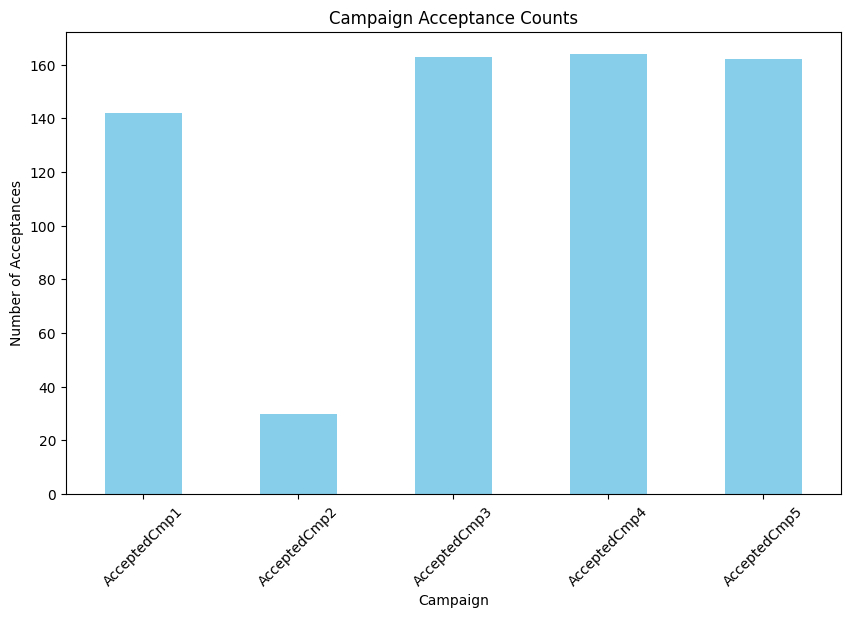

<ipython-input-7-f887ac61251d>:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=group, y='Response', ci=None)


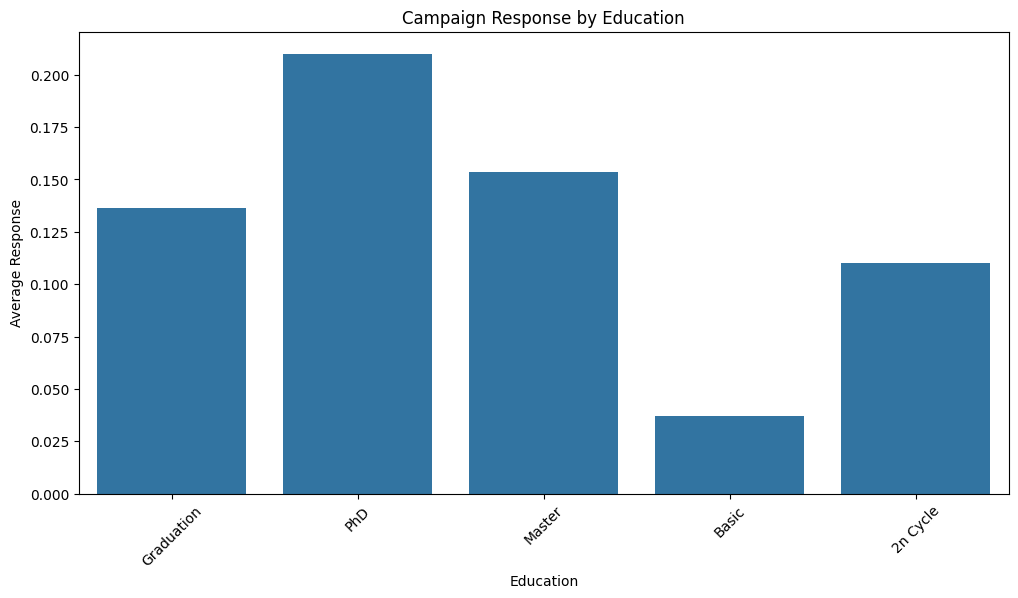

<ipython-input-7-f887ac61251d>:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x=group, y='Response', ci=None)


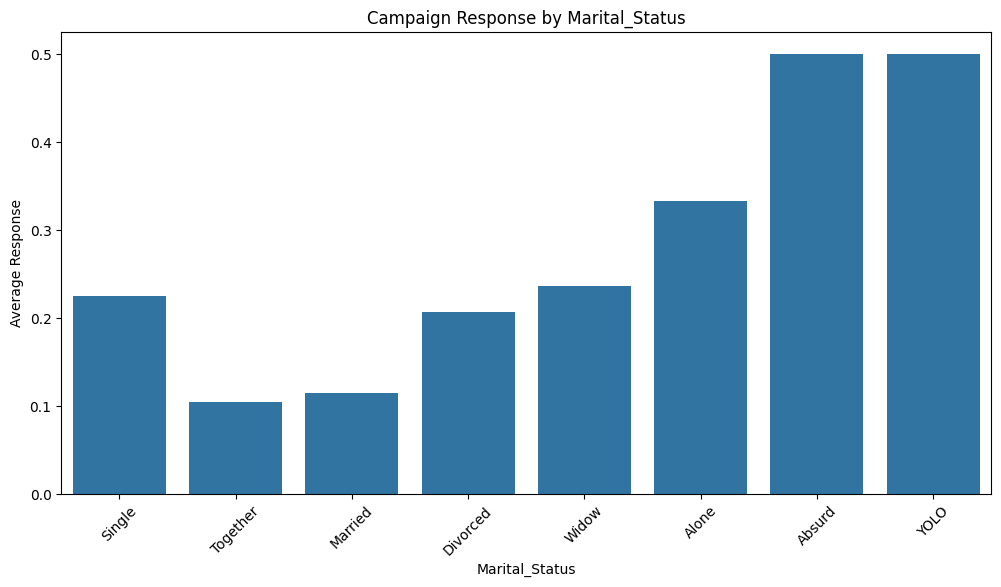

Z-test statistic: 8.71, p-value: 0.0000
The difference between Campaign 1 and Campaign 2 is statistically significant.


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       569
           1       0.00      0.00      0.00        96

    accuracy                           0.86       665
   macro avg       0.43      0.50      0.46       665
weighted avg       0.73      0.86      0.79       665

ROC-AUC Score: 0.7310


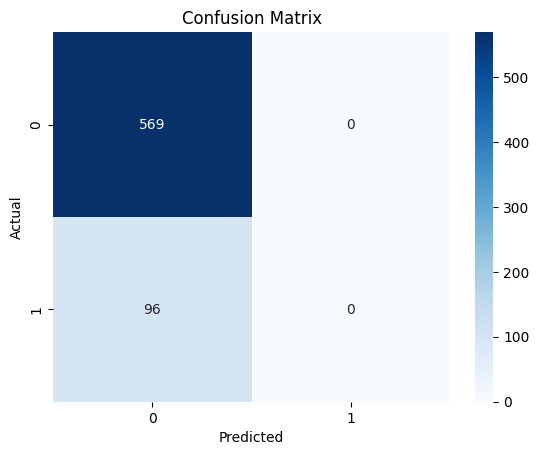

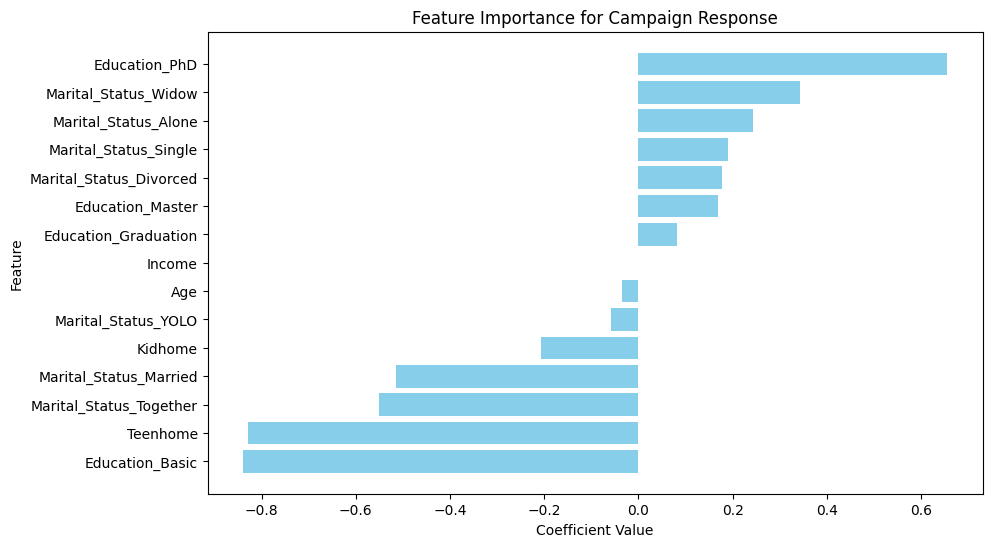

In [7]:
# Clean and preprocess data
campaign_cols = ["AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response"]
demographic_cols = ["Income", "Education", "Marital_Status", "Kidhome", "Teenhome"]

df = df[campaign_cols + demographic_cols].dropna()

# Feature engineering
# Convert Year_Birth to Age if available
if 'Year_Birth' in df.columns:
    df['Age'] = 2024 - df['Year_Birth']
    df = df.drop(columns=['Year_Birth'])
else:
    df['Age'] = 2024 - 1970  # Placeholder if Year_Birth is missing

# Summarize campaign acceptance
campaign_summary = df[campaign_cols[:-1]].sum(axis=0)
plt.figure(figsize=(10, 6))
campaign_summary.plot(kind='bar', color='skyblue')
plt.title('Campaign Acceptance Counts')
plt.xlabel('Campaign')
plt.ylabel('Number of Acceptances')
plt.xticks(rotation=45)
plt.show()

# Analyze campaign response by demographics
demographic_groups = ['Education', 'Marital_Status']
for group in demographic_groups:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x=group, y='Response', ci=None)
    plt.title(f'Campaign Response by {group}')
    plt.ylabel('Average Response')
    plt.xticks(rotation=45)
    plt.show()

# Perform A/B testing between Campaign 1 and Campaign 2
# Proportions of acceptance
cmp1_accepted = df['AcceptedCmp1'].sum()
cmp2_accepted = df['AcceptedCmp2'].sum()
n_cmp1 = len(df['AcceptedCmp1'])
n_cmp2 = len(df['AcceptedCmp2'])

# Z-test
stat, p_value = proportions_ztest([cmp1_accepted, cmp2_accepted], [n_cmp1, n_cmp2])
print(f"Z-test statistic: {stat:.2f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("The difference between Campaign 1 and Campaign 2 is statistically significant.")
else:
    print("No significant difference between Campaign 1 and Campaign 2.")

# Build a logistic regression model to predict campaign response
X = pd.get_dummies(df[demographic_cols + ['Age']], drop_first=True)
y = df['Response']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train logistic regression model
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance (logistic regression coefficients)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Coefficient'], color='skyblue')
plt.title('Feature Importance for Campaign Response')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()


## Interpretation of Results

### Campaign Acceptance Counts
- Campaigns 3, 4, and 5 have the highest acceptance counts, suggesting they were more effective in engaging customers.
- Campaign 2 had significantly lower acceptance rates, indicating it may require improvement in design or targeting.

### Campaign Response by Education
- Customers with higher education levels (PhD) tend to respond more positively to campaigns.
- Customers with basic education have the lowest response rates, suggesting education might influence engagement.

### Campaign Response by Marital Status
- Unconventional marital statuses such as "YOLO" and "Absurd" show the highest response rates, possibly due to unique lifestyle preferences.
- Married and "Together" customers have lower response rates, indicating these groups might require different strategies.

### A/B Testing Between Campaign 1 and Campaign 2
- Z-test results indicate whether the acceptance rates of Campaign 1 and Campaign 2 are statistically different.
- If the p-value is significant (<0.05), Campaign 1 and Campaign 2 differ significantly in effectiveness.

### Logistic Regression Model Evaluation
- **Precision**: High precision for class `0` (non-responders) but zero for class `1` (responders), meaning the model struggles to identify actual responders.
- **Recall**: Recall for class `1` is also zero, reinforcing that the model fails to capture positive responses.
- **F1-score**: Weighted average F1-score is 0.79, driven mainly by the majority class (non-responders).
- **ROC-AUC**: The score of 0.7310 suggests moderate discriminatory power but highlights room for improvement in separating responders from non-responders.

### Confusion Matrix
- The model correctly identifies all non-responders but fails entirely to predict any responders (`96` misclassified as `0`).
- This imbalance is likely due to skewed response data and suggests the need for resampling or alternative modeling techniques.

### Business Insights
1. **Campaign Adjustments**:
   - Focus on replicating strategies from Campaigns 3, 4, and 5 for higher effectiveness.
   - Reevaluate Campaign 2 to identify shortcomings in content or targeting.

2. **Customer Targeting**:
   - Prioritize customers with higher education levels and unconventional marital statuses.
   - Develop separate strategies for less engaged groups like married or lower-educated individuals.

3. **Model Improvement**:
   - Address class imbalance in the response variable using oversampling techniques (e.g., SMOTE) or weighted models.
   - Consider ensemble methods like Random Forest or Gradient Boosting to improve predictive performance.

4. **A/B Testing Expansion**:
   - Expand A/B testing to include comparisons of other campaign pairs to identify consistently successful strategies.